# Hologram Capture Masking Logic Example

## Import Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

: 

In [4]:
import os
os.getcwd()

'c:\\Users\\Aniket_W10\\Documents\\Workspace'

## Capture Image Masking Function (Hard Mask & Smooth Mask)

Make sure to give coordinate values in sequence

Find coordinates from ImageJ (x, y) pair in order, no need to swap

Coordinate value in sequence meaning:

1 - left-up; 2 - right-up; 3 - right-bottom; 4 - left-bottom

In [17]:
def mask_image_smooth(image_path, corners, border_width=20):
    """
    Masks out the region outside the given quadrilateral corners and creates a smooth border.
    :param image_path: Path to the input image.
    :param corners: List of four (x, y) coordinates defining the quadrilateral.
    :param border_width: Width of the smoothing border in pixels.
    """

    image = cv2.imread(image_path) # read image
    if image is None:
        raise ValueError("Image not found or invalid path.")
    
    mask = np.zeros(image.shape[:2], dtype=np.uint8) # empty mask, same shape as an image
    pts = np.array(corners, dtype=np.int32).reshape((-1, 1, 2)) # corners into numpy array, reshape for polygon fill
    cv2.fillPoly(mask, [pts], 255) # polygon fill
    mask_img = cv2.bitwise_and(image, image, mask=mask) # masked image

    border_mask = np.zeros(image.shape[:2], dtype=np.uint8) # extended border area (smooth out region)mask_img = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    
    x_coords = [p[0] for p in corners] # x-coord only
    y_coords = [p[1] for p in corners] # y-coord only
    min_x, max_x = min(x_coords), max(x_coords) # min & max coords among x-coords
    min_y, max_y = min(y_coords), max(y_coords) # min & max coords among y-coords
    
    # border area coordinates
    min_x_border = max(0, min_x - border_width)
    min_y_border = max(0, min_y - border_width)
    max_x_border = min(image.shape[1], max_x + border_width)
    max_y_border = min(image.shape[0], max_y + border_width)
    
    border_pts = np.array([[min_x_border, min_y_border],
        [max_x_border, min_y_border],
        [max_x_border, max_y_border],
        [min_x_border, max_y_border]
    ], dtype=np.int32).reshape((-1, 1, 2))

    cv2.fillPoly(border_mask, [border_pts], 255) # polygon fill

    border_pixels = image.copy()
    border_pixels = cv2.bitwise_and(border_pixels, border_pixels, mask=255 - mask) # exclude the masked area from the border pixels
    border_pixels = cv2.bitwise_and(border_pixels, border_pixels, mask=border_mask) # include only the border area in the border pixels
    border_pixel_values = border_pixels[border_pixels.any(axis=2)] # get the non-zero pixel values
    # border_pixel_values = mask_img[mask_img.any(axis=2)] # little brighter pixel values

    # average pixel value based on the border of the hologram
    if border_pixel_values.size > 0: avg_border_color = np.mean(border_pixel_values, axis=0).astype(np.uint8)
    else: avg_border_color = np.array([0, 0, 0], dtype=np.uint8)

    color_scheme = np.linspace(avg_border_color, [0, 0, 0], border_width + 1, dtype=np.uint8)[1:] # color palette
    smooth_masked_image = image.copy()
    layer_masks = [mask.copy()] # original polygon mask

    for i in range(border_width): # dilate the mask to create layers from the border
        dilated_mask = cv2.dilate(layer_masks[-1], np.ones((3, 3), np.uint8), iterations=1)
        layer_masks.append(dilated_mask)

    for i in range(border_width):
        color = color_scheme[i] # current layer's color
        layer_mask = layer_masks[i + 1] - layer_masks[i] # current layer mask
        smooth_masked_image = np.where(layer_mask[:, :, np.newaxis] == 255, color, smooth_masked_image).astype(np.uint8) # apply the color to the current layer

    # fill the gap with black
    gap_mask = border_mask - layer_masks[-1]
    smooth_masked_image = np.where(gap_mask[:, :, np.newaxis] == 255, [0, 0, 0], smooth_masked_image).astype(np.uint8)

    smooth_masked_image = np.where(mask[:, :, np.newaxis] == 255, image, smooth_masked_image).astype(np.uint8) # combine original image & smooth mask
    smooth_masked_image = cv2.bitwise_and(smooth_masked_image, smooth_masked_image, mask=border_mask) # apply border mask to the smooth mask image
    
    return mask_img, smooth_masked_image

## Capture Masking Logic Applied -> Save

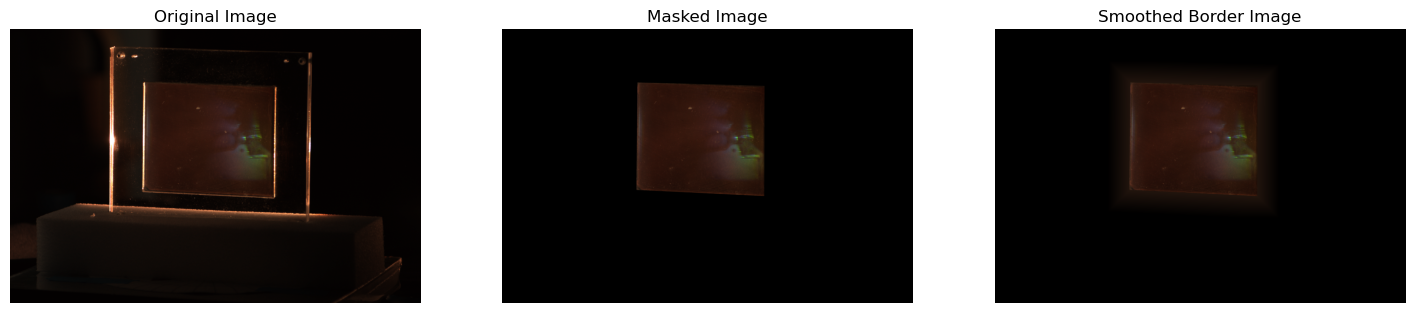

In [ ]:
filename = "H142 - A 15 degree - RGB.png"
image_path = "../rgb_merged/images/" + filename  # Change this to your image path
corners = [(1804, 712),(3495, 755),(3491, 2223),(1791, 2143)]  # Example quadrilateral

result, smoothed_result = mask_image_smooth(image_path, corners, border_width=300)
original = cv2.imread(image_path)
    
# Plot original, masked, and smoothed images side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(original)
axes[0].axis("off")
axes[0].set_title("Original Image")

axes[1].imshow(result)
axes[1].axis("off")
axes[1].set_title("Masked Image")

axes[2].imshow(smoothed_result)
axes[2].axis("off")
axes[2].set_title("Smoothed Border Image")

plt.show()


img1 = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite('./rgb_merged_mask/images/' + filename, img1)

img2 = cv2.cvtColor(smoothed_result, cv2.COLOR_RGB2BGR)
cv2.imwrite('./rgb_merged_mask_smooth/images/' + filename, img2)